In [1]:
#Llamamos las paquetrías que necesitaremos
from functools import partial #Funciones de orden superior
from collections import defaultdict #Llama a una función de fábrica para suministrar valores perdidos
import numpy as np
import matplotlib.pyplot as plt # Ploteo
import scipy.integrate #Librería de integración
import sympy 
from mpl_toolkits.mplot3d import axes3d #Used for the 3d bifurcation plot
import matplotlib.patches as mpatches #Leyendas personalizadas
%matplotlib inline

# Modelo de Cloutier (enfermedad de Parkinson)
[Cloutier et al. (2012)](https://www.ncbi.nlm.nih.gov/pubmed/22757587)

$$\frac{d ROS}{d t} =  \underbrace{ \overbrace{K1}^{720\frac{\mu M}{h}} \left[ 1+S1+\overbrace{d_{\alpha}SYN}^{15} \left( \frac{(\alpha SYNmis/\overbrace{ k_{\alpha}SYN}^{8.5 \mu m})^4)}{(1+(\alpha SYNmis /k_{\alpha}SYN)^4} \right) \right]}_{v_1 = \text{generación de ROS}} - \underbrace{\overbrace{K_2}^{\frac{720}{h}} ROS {\text{X}}S2}_{v2= \text{eliminación de ROS}}$$

$$\frac{d \alpha SYNmis}{d t} = \underbrace{\overbrace{K_3}^{\frac{0.007}{h}} ROS\text{X}S3}_{v_3 = \text{generación de $\alpha SYN$}}- \underbrace{ \overbrace{K4}^{\frac{0.007}{h}} \alpha SYNmis \text{X}S4}_{v_4 = \text{degradación de $\alpha SYN$}}$$

$ROS =$ Concentración de especies reactivas de oxígeno\
$\alpha - SYNmis=$ Concentracón de $\alpha$-sinucleína mal plegada\
$S_1 =$ Estrés oxidativo interno y externo\
$S_2 =$ Mecanismo antioxidativo\
$S_3 =$ Daños y mutaciones genéticas\
$S_4 =$ Degradación de proteínas

**Observación:** En la primera ecuación tenemos $k_1 = k_2 =720 $ mientras que en la segunda $k_3 = k_4 = 0.007$ 
Hay una clara diferencia de cinco órdenes de magnitud, por lo que en el campo vectorial tendremos mayor cambio en el eje $ROS$. Para tener una mejor visualización de éste reescaleremos el sistema dividiendo la primera ecuación entre $10^4$.

In [28]:
#Declaramos dos casos para nuestros parámetros
#Para S1 < 2.4 tendremos un sistema biestable (si dejamos a los demás parámetros en su valor nominal
#Para S1 > 2.42 tendremos un sólo estado estable

scenarios = [{'S1':0, 'S2':1, 'S3':1, 'S4':1, 'K1':720, 'K2':720, 'K3':0.007, 'K4':0.007, 'daSYN':15, 'kaSYN':8.5},
             {'S1':3, 'S2':1, 'S3':1, 'S4':1, 'K1':720, 'K2':720, 'K3':0.007, 'K4':0.007, 'daSYN':15, 'kaSYN':8.5}]

# Tiempo de integración para las trayectorias
time = np.linspace(0, 1000, 9000)

#Declaramos distintas condiciones iniciales:
#initial_conditions = [(0,0),(3,4),(6,5),(7.8,9),(9,7.8),(13,11),(15,18),(20,20)]
initial_conditions = [(6,5),(9,7.8),(7.91,7.91),(8.5,8.5),(9,7.8),(13,11),(15,18),(3,13),(5,20),(20,3),(1,11),(9,2),(7.8,15),(1,7.8),(0,8.5),(25,6.3)]

In [29]:
def Cloutier(y, t, S1, S2, S3, S4, K1, K2, K3, K4, daSYN, kaSYN):
    """ Definimos el modelo de Cloutier
    Argumentos:
        y (array): (concentraciónn de ROS, concentración de aSYNmis)
        t (float): tiempo 
        S1(float): Estrés oxidativo interno y externo
        S2(float): Mecanismo antioxidativo
        S3(float): Daños y mutaciones genéticas
        S4(float): Degradación de proteínas
    Regresa: dy/dt
    """
    ROS, aSYNmis = y
    return np.array([(K1*(1+S1+daSYN*((aSYNmis/kaSYN)**4)/(1+(aSYNmis/kaSYN)**4))-K2*ROS*S2)/10**4,
                     K3*ROS*S3-K4*aSYNmis*S4])

In [30]:
# Simulamos las trayectorias para ROS y aSYNmis del modelo de Cloutier
trajectory = {}
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        trajectory[i,j] = scipy.integrate.odeint(partial(Cloutier, **param),
                                                 y0=ic,
                                                 t=time)

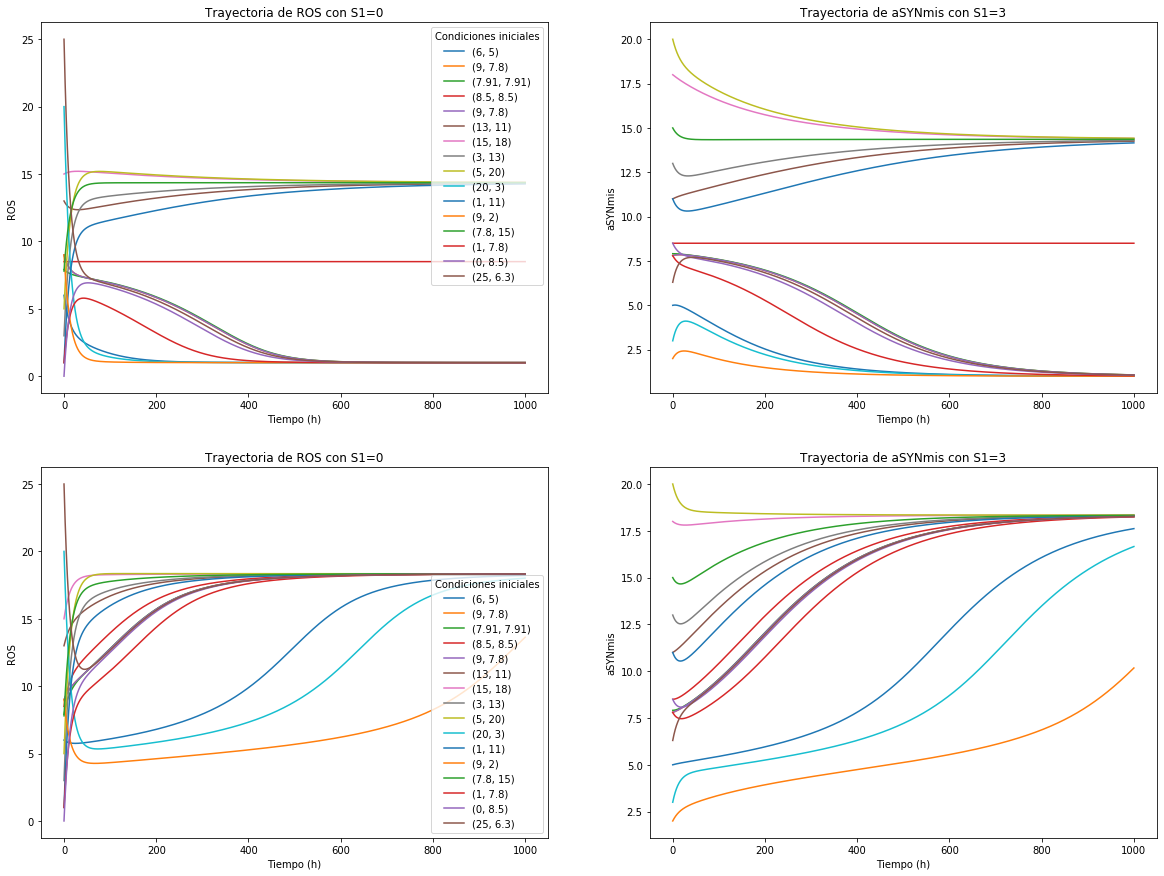

In [31]:
# Dibujamos las trayectorias simuladas de arriba 
fig, ax = plt.subplots(2,2,figsize=(20,15))
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        ax[i][0].set(xlabel='Tiempo (h)', ylabel='ROS', title='Trayectoria de ROS con S1=0')
        ax[i][1].set(xlabel='Tiempo (h)', ylabel='aSYNmis', title='Trayectoria de aSYNmis con S1=3'.format(param))
        l = ax[i][0].plot(time,trajectory[i,j][:,0], label=ic)
        ax[i][1].plot(time,trajectory[i,j][:,1], color=l[0].get_color())
    ax[i][0].legend(title='Condiciones iniciales')

In [32]:
 #Definimos el espacio (coordenadas) de nuestro plano ROS,aSYNmis
ROSspace = np.linspace(0,25,1000)
aSYNspace = np.linspace(0,25,1000)

### Ceroclinas

La ceroclinas de un sistema $F(x,y)$, donde:

$$\dot x = f(x,y)$$    y
$$\dot y = g(x,y)$$

Son aquellas donde $\dot x = 0$  y  $\dot y = 0$. Para encontrar las nuestras necesitamos tener $\frac{dROS}{dt}=0$ y $\frac{daSYNmis}{dt}=0$, es decir:

$$K1 \left[ 1+S1+d_{\alpha}SYN \left( \frac{(\alpha SYNmis/k_{\alpha}SYN)^4)}{(1+(\alpha SYN/k_{\alpha}SYN)^4} \right) \right] -K_2 ROS {\text{X}}S2 = 0$$

$$K_3 ROS\text{X}S3-K4 \alpha SYNmis \text{X}S4 = 0$$

Despejando $ROS$ y $\alpha SYN_{mis}$, respectivamente:

$$K_1 \left[ 1+S1+d_{\alpha}SYN \left( \frac{(\alpha SYNmis/k_{\alpha}SYN)^4)}{(1+(\alpha SYN/k_{\alpha}SYN)^4} \right) \right]/ K_2\text{X} S_2 = ROS$$


$$\alpha SYNmis = \frac{k_3 ROS \times S_3}{k_4 S_4}$$


In [33]:
#Definimos las ceroclinas es decir, donde f(ROS,aSYNmis)=0
def plot_isocline(ax, ROSspace, aSYNspace, S1, S2, S3, S4, K1, K2, K3, K4, daSYN, kaSYN, style='--'):
#, color='k', style='--', opacity=.5
    """Ploteamos las ceroclinas, definimos las coordenadas
    con lo obtenido arriba"""
    ax.plot((K1*(1+S1+daSYN*((aSYNspace/kaSYN)**4)/(1+(aSYNspace/kaSYN)**4)))/(K2*S2), aSYNspace, color='C22', label='ROS')
    ax.plot(ROSspace, (K3*ROSspace*S3)/(K4*S4), style, color='orange',label='aSYNmis')
    ax.set(xlabel='ROS',ylabel='aSYNmis')
    ax.legend()

In [34]:
#Definimos el campo vectorial 
def plot_flow(ax, param, ROSspace, aSYNspace):
    X,Y = np.meshgrid(ROSspace,aSYNspace)
    a = Cloutier([X,Y],0,**param)   
    ax.streamplot(X,Y,a[0,:,:], a[1,:,:], color=(0,0,0,.1))
    ax.set(xlim=(ROSspace.min(),ROSspace.max()), ylim=(aSYNspace.min(),aSYNspace.max()))

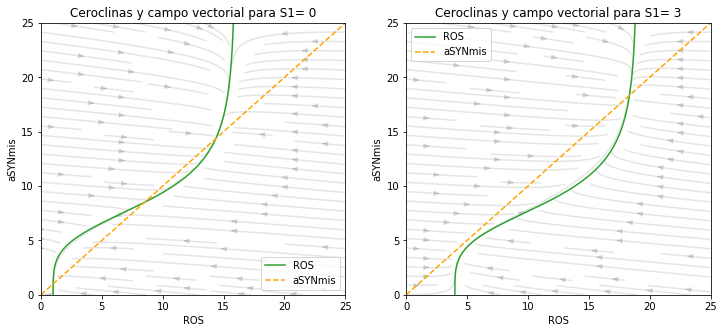

In [35]:
S1_space=[0,3]
#Graficamos ceroclinas y campo vectorial
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(scenarios):
    #Nombre de los ejes y título
    ax[i].set(xlabel='ROS', ylabel='aSYNmis', title="Ceroclinas y campo vectorial para S1= {}".format(S1_space[i]))
    #Campo vectorial
    plot_flow(ax[i], param, ROSspace=ROSspace, aSYNspace=aSYNspace)
    #Ceroclinas
    plot_isocline(ax[i], ROSspace=ROSspace, aSYNspace=aSYNspace, **param)

Observamos que para $S_1 =0$ hay tres puntos críticos y para $S_1 = 3$ sólo hay uno.
Lo que queremos ver ahora es el tipo y estabilidad de los puntos críticos.
Para ello necesitamos obtener la jacobiana del sistema, evaluar sus puntos críticos y considerar los valores propios si su parte real es mayor a $0$.

In [36]:
#Buscamos las raíces para cada lista de parámentros y condiciones iniciales
def findroot(func, init): 
    """ Find root of equation function(x)=0
    Args:
        - Sistema de Cloutier (function),
        - Condiciones iniciales (list or np.array)
          (Definidas anteriormente) 

    return: Los puntos de equilibrio (type np.array) 
            si el método numérico converge o return nan
    """
    sol, info, convergence, sms = scipy.optimize.fsolve(func, init, full_output=1)
    if convergence == 1:
        return sol
    return np.array([np.nan]*len(init))

In [37]:
def find_unique_equilibria(flow, starting_points):
    #Obtenemos los únicos puntos de equilibrio
    equilibria = [] 
    roots = [findroot(flow, init) 
             for init in starting_points]
    #Los guardamos
    for r in roots:
        if (not any(np.isnan(r)) and
            not any([all(np.isclose(r, x)) for x in equilibria])):
            equilibria.append(r)
    return equilibria

equilibria = {}
for i, param in enumerate(scenarios):
    
    # Encontramos la posición de los puntos de equilibrio alrededor del último centésimo punto de la trayectoria. 
    flow = partial(Cloutier,t=0, **param)
    #AQUÍ ES DONDE SE PONE EL -100 YA QUE QUEREMOS INICIAR 100 PUNTOS ANTES DEL PUNTO FINAL DE LA TRAYECTORIA
    starting_points = [trajectory[i,j][-100,:] for j 
                       in range(len(initial_conditions))] 
    equilibria[i] = find_unique_equilibria(flow, starting_points)
    print('{} Puntos de equilibrio para parámetros: {}'.format(len(equilibria[i]), param))

3 Puntos de equilibrio para parámetros: {'S1': 0, 'S2': 1, 'S3': 1, 'S4': 1, 'K1': 720, 'K2': 720, 'K3': 0.007, 'K4': 0.007, 'daSYN': 15, 'kaSYN': 8.5}
1 Puntos de equilibrio para parámetros: {'S1': 3, 'S2': 1, 'S3': 1, 'S4': 1, 'K1': 720, 'K2': 720, 'K3': 0.007, 'K4': 0.007, 'daSYN': 15, 'kaSYN': 8.5}


In [38]:
#Imprimimos los puntos de equilibrio
print(equilibria)

{0: [array([1.00290652, 1.00290652]), array([8.5, 8.5]), array([14.35988344, 14.35988344])], 1: [array([18.33817169, 18.33817169])]}


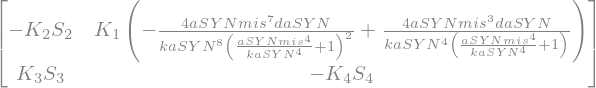

In [39]:
sympy.init_printing()

# Deefinimos las variables
ROS, aSYNmis = sympy.symbols("ROS, aSYNmis")
#Definimos los parámetros
S1, S2, S3, S4, K1, K2, K3, K4, daSYN, kaSYN = sympy.symbols("S1, S2, S3, S4, K1, K2, K3, K4, daSYN, kaSYN")

#Expresamos al sistema con la forma simbólica de arriba (la original)
dROSdt = K1*(1+S1+daSYN*((aSYNmis/kaSYN)**4)/(1+(aSYNmis/kaSYN)**4))-K2*ROS*S2
daSYNmisdt = K3*ROS*S3-K4*aSYNmis*S4

#Definimos simbólicamente los elementos para nuestra matriz jacobiana
sys = sympy.Matrix([dROSdt, daSYNmisdt])
var = sympy.Matrix([ROS, aSYNmis])
jac = sys.jacobian(var)

#Definimos a la matriz jacobiana del sistema
jacobian_Cloutier = sympy.lambdify((ROS, aSYNmis, S1, S2, S3, S4, K1, K2, K3, K4, daSYN, kaSYN), jac, dummify=False)

#Imprimimos la matriz
jac

In [40]:
#Definimos la estabilidad y tipo de los puntos de equilibrio con la matriz jacobiana
def stability(jacobian):
    """ La estabilidad de los puntos de equilibrio está
    determninada por la matriz jacobiana obtenida 
    Args:
        jacobian (np.array 2x2): Matriz jacobiana evaluada en el punto de 
        equilibrio.
    Return:
        (string) Tipo de punto de equilibrio 
    """
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = "Cetro (Hopf)"
    elif np.isclose(determinant,0):
        nature = "Transcrítico (Silla-Nodo)"
    elif determinant < 0:
        nature = "Silla"
    else:
        nature = "Foco" if (trace**2 - 4 * determinant) < 0 else "Nodo"
        nature += " estable" if trace < 0 else " inestable"
        
    return nature

In [41]:
# Evaluamos para encontrar el tipo de punto
equilibria_nature = {}
for i, param in enumerate(scenarios):
    print('\nParameters: {}'.format(param))
    equilibria_nature[i] = []
    for (ROS,aSYNmis) in equilibria[i]:
        equilibria_nature[i].append(stability(jacobian_Cloutier(ROS,aSYNmis, **param)))
        print("{} in ({} {})".format( equilibria_nature[i][-1], ROS,aSYNmis,))


Parameters: {'S1': 0, 'S2': 1, 'S3': 1, 'S4': 1, 'K1': 720, 'K2': 720, 'K3': 0.007, 'K4': 0.007, 'daSYN': 15, 'kaSYN': 8.5}
Nodo estable in (1.002906519315002 1.002906519315002)
Silla in (8.5 8.5)
Nodo estable in (14.359883443346227 14.359883443346227)

Parameters: {'S1': 3, 'S2': 1, 'S3': 1, 'S4': 1, 'K1': 720, 'K2': 720, 'K3': 0.007, 'K4': 0.007, 'daSYN': 15, 'kaSYN': 8.5}
Nodo estable in (18.3381716881557 18.3381716881557)


In [42]:
EQUILIBRIUM_COLOR = {'Nodo estable':'C0',
                    'Nodo inestable':'C1', 
                    'Silla':'C3',
                    'Foco estable':'C2',
                    'Foco inestable':'C4',
                    'Centro (Hopf)':'C5',
                    'Transcrítico (Silla-Nodo)':'C6'}
def plot_equilibrium(ax, position, nature, legend=True):
    """Graficamos los puntos de equilibrio at position with the color 
       corresponding to their nature"""
    for pos, nat in zip(position,nature):
        ax.scatter(pos[0],pos[1],
                   color= (EQUILIBRIUM_COLOR[nat] 
                           if nat in EQUILIBRIUM_COLOR
                           else 'k'),
                   zorder=100)
        
    if legend:
        # Draw a legend for the equilibrium types that were used.
        labels = list(frozenset(nature))
        ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels)

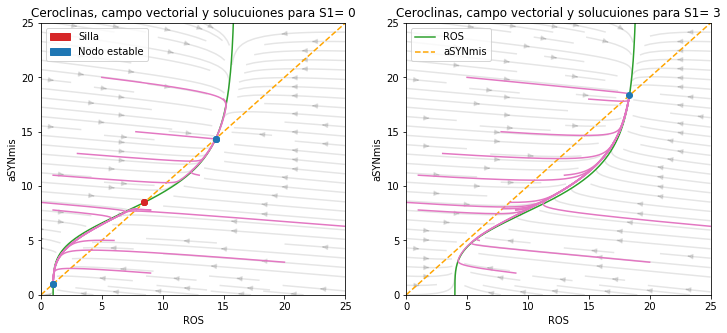

In [46]:
S1_space=[0,3]
#Graficamos ceroclinas, trayectorias, campo vectorial y puntos de equilibrio
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(scenarios):
    ax[i].set(xlabel='ROS', ylabel='aSYNmis', title="Ceroclinas, campo vectorial y solucuiones para S1= {}".format(S1_space[i]))
    plot_flow(ax[i], param, ROSspace=ROSspace, aSYNspace=aSYNspace)
    plot_isocline(ax[i], ROSspace=ROSspace, aSYNspace=aSYNspace, **param)
    for j in range(len(initial_conditions)):
        ax[i].plot(trajectory[i,j][:,0],trajectory[i,j][:,1], color='C6')
    plot_equilibrium(ax[0], equilibria[0], equilibria_nature[0])